In [22]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, converters
from numpy import pi

In [7]:
N = 15 # Number we want to factor
L = 5  # Number of bits needed to represent N

t = 12 # formula from nielsen for required qbits


In [10]:
qreg1 = QuantumRegister(t, 'q')
qreg2 = QuantumRegister(L, 'qq')

circ = QuantumCircuit(qreg1, qreg2)

for i in range(t):
  circ.reset(qreg1[i])

for i in range(L):
  circ.reset(qreg2[i])
  circ.x(qreg2[i])


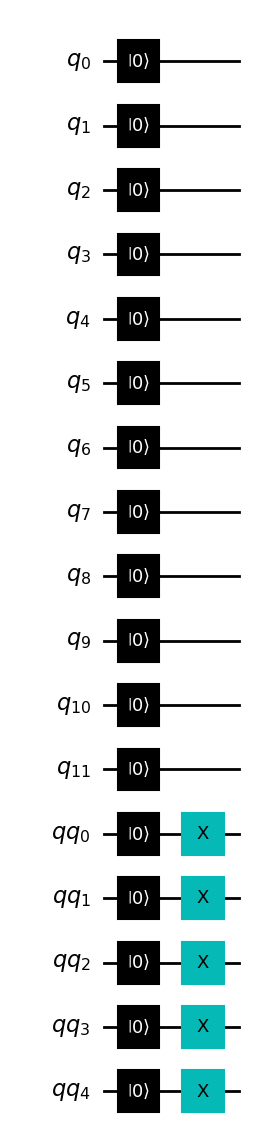

In [11]:
circ.draw("mpl")


In [17]:
# blatantly stole qft circuit generator from this:
# https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [29]:
def qft_gate(n):
  qc = QuantumCircuit(n)
  qc.name = "QFT"
  qft(qc, n)
  gate = converters.circuit_to_gate(qc)

  return gate

def inverse_qft_gate(n):
  qc = QuantumCircuit(n)
  qc.name = "QFT"
  inverse_qft(qc, n)
  gate = converters.circuit_to_gate(qc)

  return gate

In [33]:
qc = QuantumCircuit(4)

g = qft_gate(4)

qc.append(g, range(0, 4))


In [35]:
print(qc.qasm())


OPENQASM 2.0;
include "qelib1.inc";
gate gate_QFT q0,q1,q2,q3 { h q3; cp(pi/8) q0,q3; cp(pi/4) q1,q3; cp(pi/2) q2,q3; h q2; cp(pi/4) q0,q2; cp(pi/2) q1,q2; h q1; cp(pi/2) q0,q1; h q0; swap q0,q3; swap q1,q2; }
qreg q[4];
gate_QFT q[0],q[1],q[2],q[3];

